In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# Define the same model class in your new notebook
class HierarchicalMultiTaskModel(nn.Module):
    def __init__(self, base_model, hidden_dim=768, num_groups=17, num_targets=4, num_directness=3, sentiment_size=8):
        super().__init__()
        self.encoder = base_model

        self.hate_head = nn.Linear(hidden_dim, 1)
        self.directness_head = nn.Linear(hidden_dim + 1, 3)
        self.target_head = nn.Linear(hidden_dim + 3, 7)
        self.group_head = nn.Linear(hidden_dim + 7, 17)
        self.sentiment_head = nn.Linear(hidden_dim, 8)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        hate_logits = self.hate_head(pooled_output)
        directness_logits = self.directness_head(torch.cat([pooled_output, torch.sigmoid(hate_logits)], dim=1))
        target_logits = self.target_head(torch.cat([pooled_output, torch.softmax(directness_logits, dim=1)], dim=1))
        group_logits = self.group_head(torch.cat([pooled_output, torch.softmax(target_logits, dim=1)], dim=1))
        sentiment_logits = self.sentiment_head(pooled_output)

        return {
            'hate': hate_logits.squeeze(-1),
            'directness': directness_logits,
            'target': target_logits,
            'group': group_logits,
            'sentiments': sentiment_logits
        }

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/DS266/Project/Modeling/my_model/saved_tokenizer/")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = AutoModel.from_pretrained("xlm-roberta-base")
model = HierarchicalMultiTaskModel(base_model).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DS266/Project/Modeling/my_model/hierarchical_multitask_model.pt"))
model.eval()

print("Model and tokenizer loaded successfully.")

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


In [4]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_test.csv')
display(test_df.head())

,text_cleaned,language,directness_label,target_label,group_label,hatespeech,hatespeech.1,directness_label.1,target_label.1,group_label.1,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,language_encoded
0,imagine yoongi working tongue technology hands...,english,1,4,13,1,1,1,4,13,1,0,1,0,1,0,1,1,0
1,fuck retard,english,1,0,15,1,1,1,0,15,0,1,0,0,1,0,0,0,0
2,اللهم أمين @ كفرنجه,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2
3,يع كيف يشترون كذا 😷,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2
4,Réunion entre les membres de la commission fem...,french,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,1


In [5]:
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, tokenizer, texts, max_len=128):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

test_dataset = TestDataset(tokenizer, test_df['text_cleaned'].tolist())
test_loader = DataLoader(test_dataset, batch_size=32)

In [13]:
import json

json_string = """
{
    "directness": {
        "0": "direct",
        "1": "indirect",
        "2": "normal"
    },
    "target": {
        "0": "disability",
        "1": "gender",
        "2": "normal",
        "3": "origin",
        "4": "other",
        "5": "religion",
        "6": "sexual_orientation"
    },
    "group": {
        "0": "african_descent",
        "1": "arabs",
        "2": "asians",
        "3": "christian",
        "4": "gay",
        "5": "hispanics",
        "6": "immigrants",
        "7": "indian/hindu",
        "8": "individual",
        "9": "jews",
        "10": "left_wing_people",
        "11": "muslims",
        "12": "normal",
        "13": "other",
        "14": "refugees",
        "15": "special_needs",
        "16": "women"
    }
}
"""

label_maps = json.loads(json_string)

directness_map = label_maps['directness']
target_map = label_maps['target']
group_map = label_maps['group']


# Define label categories and their corresponding lists of label names in the desired order
label_categories = {
    'hatespeech': ['hatespeech'],
    'directness': directness_label_names,
    'target': target_label_names,
    'group': group_label_names,
    'sentiment': sentiment_label_names,
}

# Define the mapping for multiclass labels to their descriptive names
multiclass_label_maps = {
    'directness': directness_map,
    'target': target_map,
    'group': group_map
}

print("Directness Map:")
print(directness_map)
print("\nTarget Map:")
print(target_map)
print("\nGroup Map:")
print(group_map)

Directness Map:
{'0': 'direct', '1': 'indirect', '2': 'normal'}

Target Map:
{'0': 'disability', '1': 'gender', '2': 'normal', '3': 'origin', '4': 'other', '5': 'religion', '6': 'sexual_orientation'}

Group Map:
{'0': 'african_descent', '1': 'arabs', '2': 'asians', '3': 'christian', '4': 'gay', '5': 'hispanics', '6': 'immigrants', '7': 'indian/hindu', '8': 'individual', '9': 'jews', '10': 'left_wing_people', '11': 'muslims', '12': 'normal', '13': 'other', '14': 'refugees', '15': 'special_needs', '16': 'women'}


In [7]:
import numpy as np

# store predictions
all_preds = {
    'hate': [],
    'directness': [],
    'target': [],
    'group': [],
    'sentiments': []
}

# no gradients needed
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)

        # Process predictions
        all_preds['hate'].extend(torch.sigmoid(outputs['hate']).cpu().numpy())
        all_preds['directness'].extend(torch.softmax(outputs['directness'], dim=1).cpu().numpy())
        all_preds['target'].extend(torch.softmax(outputs['target'], dim=1).cpu().numpy())
        all_preds['group'].extend(torch.softmax(outputs['group'], dim=1).cpu().numpy())
        all_preds['sentiments'].extend(torch.sigmoid(outputs['sentiments']).cpu().numpy())

# Convert predictions to a more usable format
for key in all_preds:
    all_preds[key] = np.array(all_preds[key])

# For classification tasks, you might want to get the predicted class index
predicted_directness = np.argmax(all_preds['directness'], axis=1)
predicted_target = np.argmax(all_preds['target'], axis=1)
predicted_group = np.argmax(all_preds['group'], axis=1)

# For hate speech and sentiments, you might want to apply a threshold
predicted_hate = (np.array(all_preds['hate']) > 0.5).astype(int)
predicted_sentiments = (np.array(all_preds['sentiments']) > 0.5).astype(int)

Hate Speech Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2024
           1       0.93      0.98      0.95      1877

    accuracy                           0.96      3901
   macro avg       0.96      0.96      0.96      3901
weighted avg       0.96      0.96      0.96      3901


Confusion Matrix:


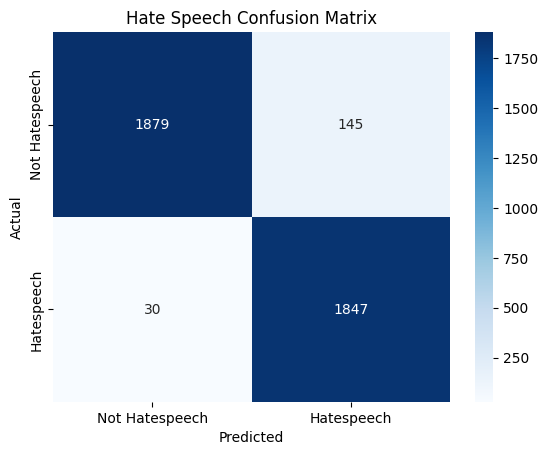


Directness Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.40      0.47       562
           1       0.77      0.91      0.83      1315
           2       0.97      0.93      0.95      2024

    accuracy                           0.85      3901
   macro avg       0.76      0.75      0.75      3901
weighted avg       0.84      0.85      0.84      3901


Confusion Matrix:


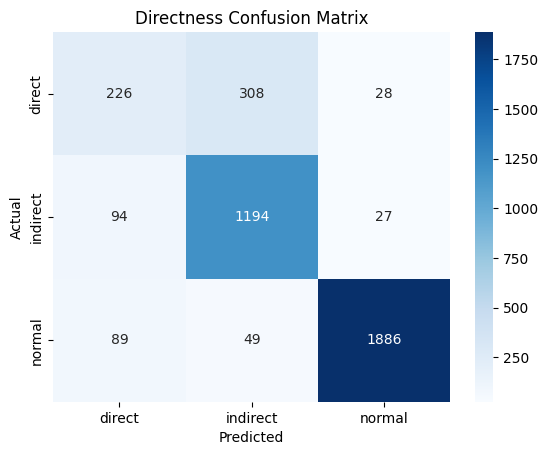


Target Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       254
           1       0.60      0.55      0.57       175
           2       0.98      0.93      0.95      2024
           3       0.78      0.75      0.76       840
           4       0.49      0.64      0.55       467
           5       0.44      0.35      0.39        52
           6       0.71      0.90      0.79        89

    accuracy                           0.82      3901
   macro avg       0.68      0.69      0.68      3901
weighted avg       0.83      0.82      0.82      3901


Confusion Matrix:


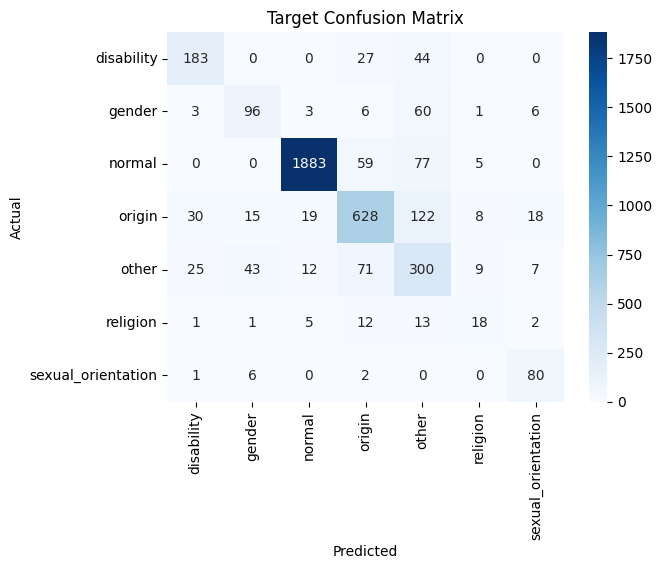


Group Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        79
           1       0.42      0.77      0.55        35
           2       0.22      0.52      0.31        27
           3       0.00      0.00      0.00         3
           4       0.48      0.37      0.42        30
           5       0.17      0.04      0.07        24
           6       0.40      0.42      0.41        43
           7       0.00      0.00      0.00        56
           8       0.40      0.43      0.42       286
           9       0.50      0.29      0.37        17
          10       0.47      0.49      0.48        71
          11       0.39      0.18      0.25        39
          12       0.97      0.94      0.95      2024
          13       0.51      0.59      0.55       578
          14       0.50      0.34      0.41        32
          15       0.72      0.72      0.72       316
          16       0.69      0.75      0.72       2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


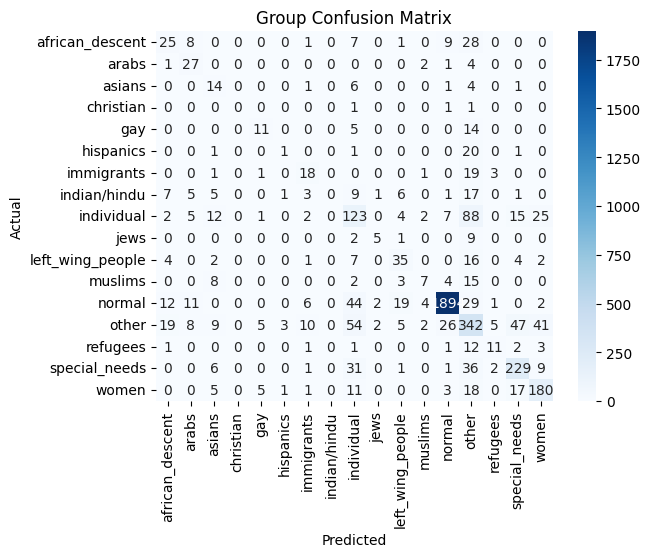


Sentiment Classification Report:

Classification Report for sentiment_anger:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3230
           1       0.52      0.73      0.61       671

    accuracy                           0.84      3901
   macro avg       0.73      0.80      0.75      3901
weighted avg       0.87      0.84      0.85      3901



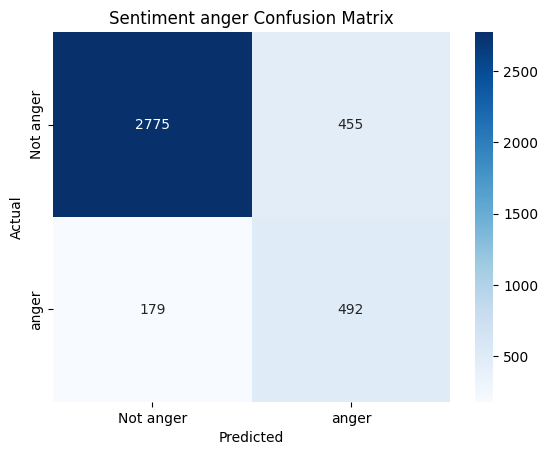


Classification Report for sentiment_confusion:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3517
           1       1.00      0.00      0.01       384

    accuracy                           0.90      3901
   macro avg       0.95      0.50      0.48      3901
weighted avg       0.91      0.90      0.86      3901



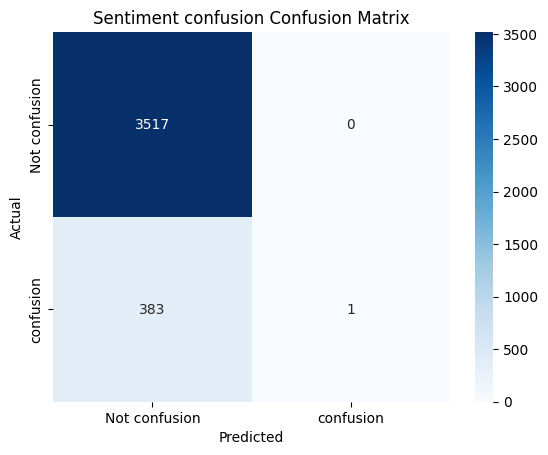


Classification Report for sentiment_disgust:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3078
           1       0.61      0.80      0.69       823

    accuracy                           0.85      3901
   macro avg       0.78      0.83      0.80      3901
weighted avg       0.87      0.85      0.86      3901



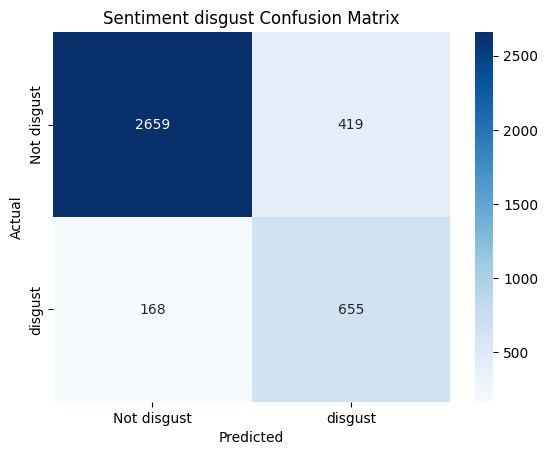


Classification Report for sentiment_fear:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3631
           1       0.00      0.00      0.00       270

    accuracy                           0.93      3901
   macro avg       0.47      0.50      0.48      3901
weighted avg       0.87      0.93      0.90      3901



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


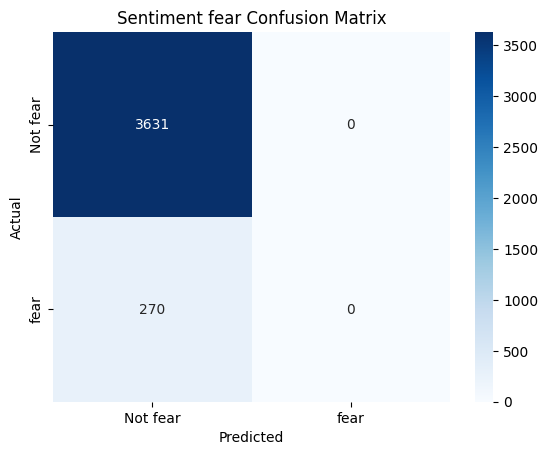


Classification Report for sentiment_indifference:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2944
           1       0.52      0.57      0.54       957

    accuracy                           0.76      3901
   macro avg       0.69      0.70      0.69      3901
weighted avg       0.77      0.76      0.77      3901



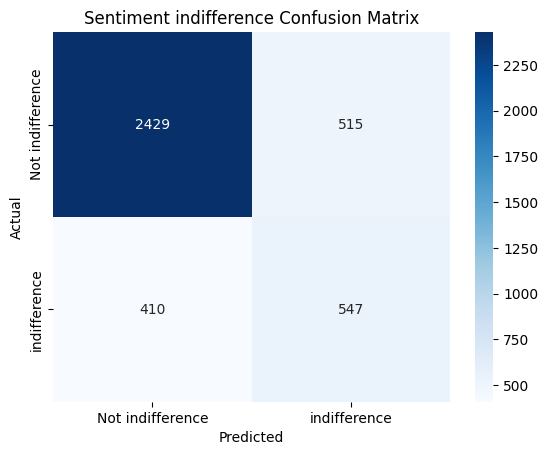


Classification Report for sentiment_normal:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1877
           1       0.98      0.93      0.96      2024

    accuracy                           0.95      3901
   macro avg       0.96      0.96      0.95      3901
weighted avg       0.96      0.95      0.95      3901



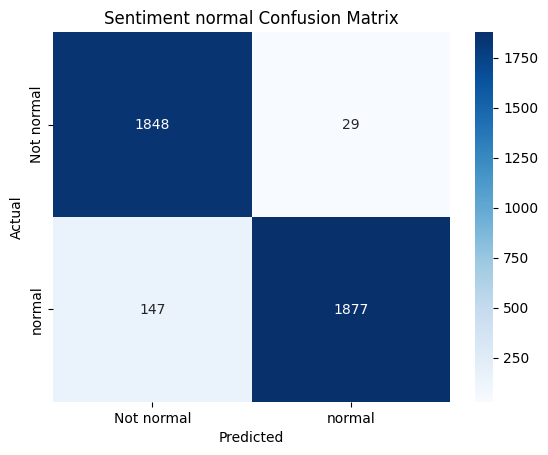


Classification Report for sentiment_sadness:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3170
           1       0.52      0.58      0.55       731

    accuracy                           0.82      3901
   macro avg       0.71      0.73      0.72      3901
weighted avg       0.83      0.82      0.82      3901



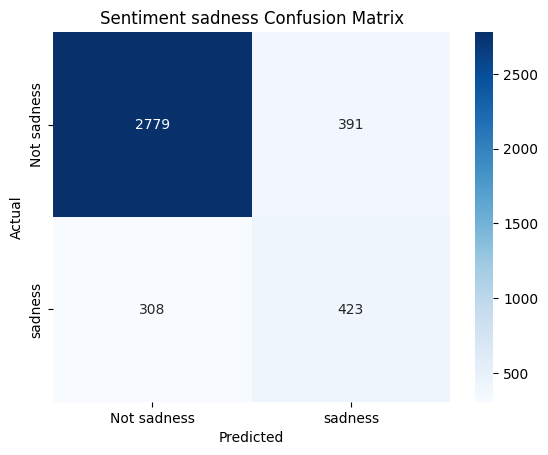


Classification Report for sentiment_shock:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      3228
           1       0.00      0.00      0.00       673

    accuracy                           0.83      3901
   macro avg       0.41      0.50      0.45      3901
weighted avg       0.68      0.83      0.75      3901



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


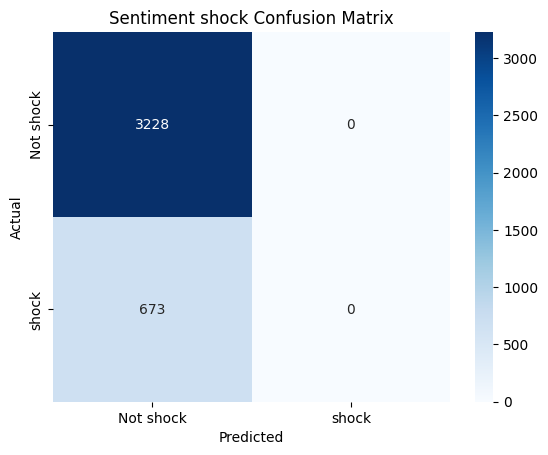

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hate Speech Evaluation
print("Hate Speech Classification Report:")
print(classification_report(test_df['hatespeech'], predicted_hate))
print("\nConfusion Matrix:")
cm = confusion_matrix(test_df['hatespeech'], predicted_hate)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hatespeech', 'Hatespeech'], yticklabels=['Not Hatespeech', 'Hatespeech'])
plt.title('Hate Speech Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Directness Evaluation
print("\nDirectness Classification Report:")
print(classification_report(test_df['directness_label'], predicted_directness))
print("\nConfusion Matrix:")
cm = confusion_matrix(test_df['directness_label'], predicted_directness)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=directness_map.values(), yticklabels=directness_map.values())
plt.title('Directness Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Target Evaluation
print("\nTarget Classification Report:")
print(classification_report(test_df['target_label'], predicted_target))
print("\nConfusion Matrix:")
cm = confusion_matrix(test_df['target_label'], predicted_target)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_map.values(), yticklabels=target_map.values())
plt.title('Target Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Group Evaluation
print("\nGroup Classification Report:")
print(classification_report(test_df['group_label'], predicted_group))
print("\nConfusion Matrix:")
cm = confusion_matrix(test_df['group_label'], predicted_group)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=group_map.values(), yticklabels=group_map.values())
plt.title('Group Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sentiment Evaluation
print("\nSentiment Classification Report:")
# Note: Sentiment is a multi-label task, so we'll look at each sentiment individually
sentiment_labels = ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']
for i, label in enumerate(sentiment_labels):
    print(f"\nClassification Report for {label}:")
    print(classification_report(test_df[label], predicted_sentiments[:, i]))
    cm = confusion_matrix(test_df[label], predicted_sentiments[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + label.split('_')[1], label.split('_')[1]], yticklabels=['Not ' + label.split('_')[1], label.split('_')[1]])
    plt.title(f'{label.replace("_", " ").capitalize()} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [9]:
from sklearn.metrics import f1_score

# Hate Speech
hate_f1_micro = f1_score(test_df['hatespeech'], predicted_hate, average='micro')

# Directness
directness_f1_micro = f1_score(test_df['directness_label'], predicted_directness, average='micro')

# Target
target_f1_micro = f1_score(test_df['target_label'], predicted_target, average='micro')

# Group
group_f1_micro = f1_score(test_df['group_label'], predicted_group, average='micro')

# Sentiments
sentiment_f1_micro = f1_score(test_df[sentiment_labels], predicted_sentiments, average='micro')

# Overall
all_true_labels = np.concatenate([
    test_df['hatespeech'],
    test_df['directness_label'],
    test_df['target_label'],
    test_df['group_label'],
    test_df[sentiment_labels].values.flatten()
])

all_predicted_labels = np.concatenate([
    predicted_hate,
    predicted_directness,
    predicted_target,
    predicted_group,
    predicted_sentiments.flatten()
])

overall_f1_micro = f1_score(all_true_labels, all_predicted_labels, average='micro')


print("Micro F1 Scores:\n")

print(f"Hate Speech F1-Score (Micro): {hate_f1_micro:.4f}")
print(f"Directness F1-Score (Micro): {directness_f1_micro:.4f}")
print(f"Target F1-Score (Micro): {target_f1_micro:.4f}")
print(f"Group F1-Score (Micro): {group_f1_micro:.4f}")
print(f"Sentiment F1-Score (Micro): {sentiment_f1_micro:.4f}\n")
print(f"Overall Model F1-Score (Micro): {overall_f1_micro:.4f}")

Micro F1 Scores:

Hate Speech F1-Score (Micro): 0.9551
Directness F1-Score (Micro): 0.8475
Target F1-Score (Micro): 0.8172
Group F1-Score (Micro): 0.7490
Sentiment F1-Score (Micro): 0.6476

Overall Model F1-Score (Micro): 0.8545


# Task
Use the provided screenshot of a LIME function to generate and display LIME explanations for 15 examples from the test set: 5 for each language (English, French, and Arabic). The test data is located at "/content/drive/MyDrive/DS266/Project/Data/combined_test.csv".

In [10]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [11]:
import lime
from lime import lime_text
import numpy as np

def lime_predictor(texts, label_index):
    """
    LIME predictor function for a specific label.

    Args:
        texts (list of str): A list of text strings to predict.
        label_index (int): The index of the target label.

    Returns:
        np.ndarray: A NumPy array of probabilities for the specified label.
    """
    # Tokenize the input texts
    encoding = tokenizer(
        texts,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=150
    )

    # Remove token_type_ids if present (some models don't accept them)
    if 'token_type_ids' in encoding:
        del encoding['token_type_ids']

    # Move tensors to the same device as the model
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**encoding)

    # Determine which output to use based on the label_index
    if label_index == 0:  # hatespeech
        logits = outputs['hate']
        probs = torch.sigmoid(logits).cpu().numpy()
        # For binary classification, LIME needs probabilities for both classes
        return np.array([1 - probs, probs]).T
    elif 1 <= label_index <= 8:  # sentiments
        logits = outputs['sentiments']
        probs = torch.sigmoid(logits).cpu().numpy()
        # Return probabilities for the specific sentiment label
        return np.array([1 - probs[:, label_index - 1], probs[:, label_index - 1]]).T
    else: # directness, target, or group
        # Determine the category from the global label_index
        if label_index < (9 + len(directness_label_names)):
            category = 'directness'
        elif label_index < (9 + len(directness_label_names) + len(target_label_names)):
            category = 'target'
        else:
            category = 'group'

        logits = outputs[category]
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

In [28]:
explainer = lime_text.LimeTextExplainer(class_names=['not_label', 'is_label'])

# Store examples for explanation, with more specific categories
explanation_examples = {}

# Get the original language information for the test dataset
languages = test_df['language'].values


# Define label name lists
sentiment_label_names = [
    "sentiment_anger",
    "sentiment_confusion",
    "sentiment_disgust",
    "sentiment_fear",
    "sentiment_indifference",
    "sentiment_normal",
    "sentiment_sadness",
    "sentiment_shock"
]
directness_label_names = [f'directness_label_{val}' for val in sorted(train_df['directness_label'].unique().tolist())]
target_label_names = [f'target_label_{val}' for val in sorted(train_df['target_label'].unique().tolist())]
group_label_names = [f'group_label_{val}' for val in sorted(train_df['group_label'].unique().tolist())]

# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

# One-hot encode the true labels from test_df
test_df_one_hot = pd.get_dummies(test_df, columns=['directness_label', 'target_label', 'group_label'])

# Align columns with all_binary_labels and ensure all columns exist
for col in all_binary_labels:
    if col not in test_df_one_hot.columns:
        test_df_one_hot[col] = 0

# Ensure the order of columns in test_df_one_hot matches all_binary_labels
test_df_one_hot = test_df_one_hot[all_binary_labels + ['text_cleaned', 'language']]


true_labels_np = test_df_one_hot[all_binary_labels].values


# Define true_labels_np and predicted_binary_labels_np
predicted_binary_labels_np = np.hstack([
    predicted_hate.reshape(-1, 1),
    (np.array(all_preds['sentiments']) > 0.5).astype(int),
    np.eye(len(directness_values))[predicted_directness],
    np.eye(len(target_values))[predicted_target],
    np.eye(len(group_values))[predicted_group]
])


for lang in ['english', 'french', 'arabic']:
    explanation_examples[lang] = {}
    for category_name in ['hatespeech', 'directness', 'target', 'group', 'sentiment']:
        explanation_examples[lang][category_name] = {}

        labels_in_category = label_categories[category_name]
        lang_indices = np.where(languages == lang)[0]

        for label_name in labels_in_category:
            explanation_examples[lang][category_name][label_name] = {
                'correct_is_label': None,
                'correct_not_label': None,
                'incorrect_is_label': None, # False Positive
                'incorrect_not_label': None  # False Negative
            }

            try:
                global_label_index = all_binary_labels.index(label_name)
            except ValueError:
                continue

            true_label_lang_indices = np.where(true_labels_np[lang_indices, global_label_index] == 1)[0]
            predicted_label_lang_indices = np.where(predicted_binary_labels_np[lang_indices, global_label_index] == 1)[0]

            # Correctly predicted "is_label" (True Positive)
            correct_is_label_lang_indices = np.intersect1d(true_label_lang_indices, predicted_label_lang_indices)
            if len(correct_is_label_lang_indices) > 0:
                original_test_df_index = lang_indices[correct_is_label_lang_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_is_label'] = {
                    'text': test_df.iloc[original_test_df_index]['text_cleaned'],
                    'label_index': global_label_index,
                    'original_test_df_index': original_test_df_index
                }

            # Correctly predicted "not_label" (True Negative)
            correct_not_label_lang_indices = np.where((true_labels_np[lang_indices, global_label_index] == 0) & (predicted_binary_labels_np[lang_indices, global_label_index] == 0))[0]
            if len(correct_not_label_lang_indices) > 0:
                original_test_df_index = lang_indices[correct_not_label_lang_indices[0]]
                explanation_examples[lang][category_name][label_name]['correct_not_label'] = {
                    'text': test_df.iloc[original_test_df_index]['text_cleaned'],
                    'label_index': global_label_index,
                    'original_test_df_index': original_test_df_index
                }


            # Incorrectly predicted "is_label" (False Positive)
            incorrect_is_label_lang_indices = np.where((true_labels_np[lang_indices, global_label_index] == 0) & (predicted_binary_labels_np[lang_indices, global_label_index] == 1))[0]
            if len(incorrect_is_label_lang_indices) > 0:
                original_test_df_index = lang_indices[incorrect_is_label_lang_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_is_label'] = {
                    'text': test_df.iloc[original_test_df_index]['text_cleaned'],
                    'label_index': global_label_index,
                    'original_test_df_index': original_test_df_index
                }

            # Incorrectly predicted "not_label" (False Negative)
            incorrect_not_label_lang_indices = np.where((true_labels_np[lang_indices, global_label_index] == 1) & (predicted_binary_labels_np[lang_indices, global_label_index] == 0))[0]
            if len(incorrect_not_label_lang_indices) > 0:
                original_test_df_index = lang_indices[incorrect_not_label_lang_indices[0]]
                explanation_examples[lang][category_name][label_name]['incorrect_not_label'] = {
                    'text': test_df.iloc[original_test_df_index]['text_cleaned'],
                    'label_index': global_label_index,
                    'original_test_df_index': original_test_df_index
                }


print("Explanation examples have been collected for each label and prediction type.")

Explanation examples have been collected for each label and prediction type.


In [29]:
import torch
import torch.nn.functional as F # Import functional for softmax

torch.cuda.empty_cache()

# Move the model to CUDA (as requested by the user, assuming CUDA is available)
if torch.cuda.is_available():
    model.to('cuda')
    device = 'cuda'
else:
    model.to('cpu')
    device = 'cpu'

def lime_predictor(texts, label_index):
    encoding = tokenizer(
        texts,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=150
    )

    if 'token_type_ids' in encoding:
        del encoding['token_type_ids']

    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)

    if label_index == 0:  # hatespeech (binary)
        logits = outputs['hate']
        probs = torch.sigmoid(logits).cpu().numpy()
        # For binary classification, LIME expects probabilities for both classes (0 and 1)
        return np.array([1 - probs, probs]).T
    elif 1 <= label_index <= 8:  # sentiments (multi-label binary)
        logits = outputs['sentiments']
        probs = torch.sigmoid(logits).cpu().numpy()
         # Return probabilities for both classes (0 and 1) for the specific sentiment label
        return np.array([1 - probs[:, label_index - 1], probs[:, label_index - 1]]).T
    else: # directness, target, or group (multiclass)
        # Determine the category from the global label_index
        if label_index < (9 + len(directness_label_names)):
            category = 'directness'
        elif label_index < (9 + len(directness_label_names) + len(target_label_names)):
            category = 'target'
        else:
            category = 'group'

        logits = outputs[category]
        probs = F.softmax(logits, dim=1).cpu().numpy() # Use F.softmax
        return probs

# Assuming explainer and multiclass_label_maps are defined in previous cells
# explainer = lime_text.LimeTextExplainer(class_names=['not_label', 'is_label'])
# multiclass_label_maps = { ... }

In [46]:
from IPython.display import display, Markdown
from lime.lime_text import LimeTextExplainer

def display_lime_explanations(lang, category_name, explanation_examples, label_categories, multiclass_label_maps, lime_predictor):
    """
    Displays LIME explanations for different prediction cases for a given language and category.

    Args:
        lang (str): The language of the examples.
        category_name (str): The name of the label category.
        explanation_examples (dict): Dictionary containing collected explanation examples.
        label_categories (dict): Dictionary mapping category names to label lists.
        multiclass_label_maps (dict): Dictionary mapping multiclass categories to descriptive label names.
        lime_predictor (function): The LIME predictor function.
    """
    labels_in_category = label_categories[category_name]

    # Create a new explainer with the correct class names
    if category_name in multiclass_label_maps:
        class_names = list(multiclass_label_maps[category_name].values())
    else:
        class_names = ['not_label', 'is_label']
    explainer = LimeTextExplainer(class_names=class_names)

    # Iterate through each label within the category
    for label_name in labels_in_category:
        if label_name in explanation_examples[lang][category_name]:
            examples = explanation_examples[lang][category_name][label_name]

            for case, example_data in examples.items():
                if example_data:
                    text = example_data['text']
                    label_index = example_data['label_index']

                    # Get the original test_df index
                    original_test_df_index = example_data.get('original_test_df_index')

                    # Check if original_test_df_index is valid
                    if original_test_df_index is None or original_test_df_index >= len(true_labels_np):
                        print(f"Skipping {case} for {label_name} in {lang}: Invalid original test_df index.")
                        continue


                    true_label = true_labels_np[original_test_df_index, label_index]
                    predicted_label = predicted_binary_labels_np[original_test_df_index, label_index]


                    # Determine the display title for the label
                    display_label_name = label_name
                    if category_name in multiclass_label_maps and '_' in label_name:
                        parts = label_name.split('_')
                        original_value = parts[-1]
                        descriptive_name = multiclass_label_maps[category_name].get(original_value, original_value)
                        display_label_name = f"{category_name.capitalize()}: {descriptive_name}"
                    else:
                        display_label_name = label_name.replace("_", " ").capitalize()

                    # Generate markdown subheading for the label and language
                    markdown_heading = f"#### {display_label_name} ({case.capitalize()})"
                    display(Markdown(markdown_heading))

                    print(f"True label: {true_label}, Predicted label: {predicted_label}")

                    print(f"Generating explanation for: {lang.capitalize()} - {display_label_name} ({case.capitalize()})")

                    try:
                        # Determine the category's labels for LIME
                        if category_name in multiclass_label_maps:
                            # Get the index of the predicted class within the category's labels
                            category_labels = label_categories[category_name]
                            predicted_class_name = all_binary_labels[np.argmax(predicted_binary_labels_np[original_test_df_index, 9:]) + 9] # Get the predicted label name
                            try:
                                predicted_class_index_in_category = category_labels.index(predicted_class_name)
                                labels_to_explain = (predicted_class_index_in_category,)
                            except ValueError:
                                print(f"Warning: Predicted class name '{predicted_class_name}' not found in category labels for {category_name}.")
                                labels_to_explain = None # Or handle appropriately
                        else:
                            # For binary/multi-label binary, explain for the positive class (index 1)
                            labels_to_explain = (1,)


                        explanation = explainer.explain_instance(
                            text,
                            lambda x: lime_predictor(x, label_index),
                            num_features=10,
                            num_samples=100,
                            labels=labels_to_explain
                        )

                        print(f"--- {lang.capitalize()}: {display_label_name} ({case.capitalize()}) ---")
                        display(explanation.show_in_notebook(text=True))

                    except Exception as e:
                        print(f"Could not generate explanation for {label_name} ({case}) in {lang}: {e}")
                        continue
        else:
             print(f"No examples found for label '{label_name}' in category '{category_name}' for language '{lang}'.")

    if not any(explanation_examples[lang][category_name][label]['correct_is_label'] or explanation_examples[lang][category_name][label]['correct_not_label'] or explanation_examples[lang][category_name][label]['incorrect_is_label'] or explanation_examples[lang][category_name][label]['incorrect_not_label'] for label in labels_in_category):
         display(Markdown(f"#### No examples found for {category_name} in {lang}"))

# English

## English - Hatespeech LIME Explanations

In [47]:
display_lime_explanations(
    lang='english',
    category_name='hatespeech',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## English - Directness LIME Explanations

In [48]:
display_lime_explanations(
    lang='english',
    category_name='directness',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## English - Target LIME Explanations

In [49]:
display_lime_explanations(
    lang='english',
    category_name='target',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## English - Group LIME Explanations

In [54]:
display_lime_explanations(
    lang='english',
    category_name='group',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## English - Sentiment LIME Explanations

In [55]:
display_lime_explanations(
    lang='english',
    category_name='sentiment',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

# French

## French - Hatespeech LIME Explanations

In [50]:
display_lime_explanations(
    lang='french',
    category_name='hatespeech',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## French - Directness LIME Explanations

In [53]:
display_lime_explanations(
    lang='french',
    category_name='directness',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## French - Target LIME Explanations

In [56]:
display_lime_explanations(
    lang='french',
    category_name='target',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## French - Group LIME Explanations

In [57]:
display_lime_explanations(
    lang='french',
    category_name='group',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## French - Sentiment LIME Explanations

In [58]:
display_lime_explanations(
    lang='french',
    category_name='sentiment',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

# Arabic

## Arabic - Hatespeech LIME Explanations

In [51]:
display_lime_explanations(
    lang='arabic',
    category_name='hatespeech',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## Arabic - Directness LIME Explanations

In [52]:
display_lime_explanations(
    lang='arabic',
    category_name='directness',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## Arabic - Target LIME Explanations

In [59]:
display_lime_explanations(
    lang='arabic',
    category_name='target',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## Arabic - Group LIME Explanations

In [60]:
display_lime_explanations(
    lang='arabic',
    category_name='group',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.

## Arabic - Sentiment LIME Explanations

In [61]:
display_lime_explanations(
    lang='arabic',
    category_name='sentiment',
    explanation_examples=explanation_examples,
    label_categories=label_categories,
    multiclass_label_maps=multiclass_label_maps,
    lime_predictor=lime_predictor
)

Output hidden; open in https://colab.research.google.com to view.